# Calibrating the number of iterations ($i_{\max}$) to run GRASP

In [51]:
import pandas as pd
from grasp_iters import read_results, DIRPATH

save = True
names = [
    "rat783_522_261_0_p20_a2", # 0
    "rat783_522_261_0_p20_a3",
    "rl1323_882_441_0_p20_a2", # 2
    "rl1323_882_441_0_p20_a3",
    "anpcp_882_441_0_p20_a2",  # 4
    "anpcp_882_441_0_p20_a3",

    "rl1323_882_441_0_p44_a2", # 6
    "rl1323_882_441_0_p44_a3",
    "anpcp_882_441_0_p44_a2",  # 8
    "anpcp_882_441_0_p44_a3",
]
name = names[9]

iters = read_results(name)
iters

,iter,beta,RGD_OF,AFVS_OF,time,is_new_best
0,0,0.667454,3952,2887,5.880586,True
1,1,0.347614,3714,2807,11.639316,True
2,2,0.618392,4428,2893,16.032229,False
3,3,0.098968,3586,2827,20.679433,False
4,4,0.685853,4888,2923,25.210293,False
...,...,...,...,...,...,...
4995,4995,0.769886,4890,2833,21245.294646,False
4996,4996,0.933589,4898,3112,21246.964082,False
4997,4997,0.410492,4206,2852,21250.197472,False
4998,4998,0.885077,4514,2907,21254.508273,False


In [52]:
iters["time"].diff().mean()

4.251157811182224

In [53]:
def get_improvs(iters_df: pd.DataFrame):
    improvs = iters_df[iters_df["is_new_best"] == True].drop("is_new_best", axis=1)

    # multiplication is negative because the problem is a minimization problem,
    # a decrease in the objective function (a negative percent change) means a better solution
    percents = improvs["AFVS_OF"].pct_change().mul(-100)
    improvs.insert(loc=4, column="imp", value=percents)

    # iterations without improvement (iwi)
    iter_diffs = improvs["iter"].diff().fillna(0).astype(int)
    improvs.insert(loc=6, column="iwi", value=iter_diffs)

    return improvs

In [54]:
improvs = get_improvs(iters)
improvs

,iter,beta,RGD_OF,AFVS_OF,imp,time,iwi
0,0,0.667454,3952,2887,NaN,5.880586,0
1,1,0.347614,3714,2807,2.771043,11.639316,1
5,5,0.624285,4315,2803,0.142501,29.699326,4
15,15,0.164596,3894,2793,0.356761,71.692373,10
20,20,0.303812,3763,2726,2.398854,95.301260,5
82,82,0.077005,3763,2714,0.440205,373.130688,62
83,83,0.724924,4471,2702,0.442152,380.924271,1
173,173,0.460059,4001,2686,0.592154,798.964110,90
312,312,0.173905,3686,2679,0.260611,1438.550006,139
647,647,0.420405,4119,2642,1.381112,2929.056326,335


In [55]:
from utils import format_latex_table

if save:
    format_latex_table(improvs, f"{DIRPATH}\\iters_improvs_{name}.tex");

c:\Users\netoo\local-personal\repos\alpha-neighbor-p-center-problem\anpcp\utils.py:104: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  dataframe.to_latex(path, float_format="%.2f", multirow=True)


In [56]:
import matplotlib.pyplot as plt

def plot_improvs(
    iters_df: pd.DataFrame,
    lastimprov: int,
    annotation_xdiff: int,
    annotation_ydiff: int,
    color: str = "blue",
    filename: str = ""
):
    fig, ax = plt.subplots(figsize=(20, 5), dpi=150)
    
    ax.plot(
        iters_df["iter"][:lastimprov],
        iters_df["AFVS_OF"].cummin()[:lastimprov],
        color=color,
    )

    for _, row in improvs.iterrows():
        of = int(row["AFVS_OF"])
        i = int(row["iter"])
        percent = row["imp"]

        ax.annotate(
            f"x(S) = {of}",
            (i, of),
            xytext=(i + annotation_xdiff, of + annotation_ydiff),
        )

    ax.set_title(f"Improvements in $S$ during GRASP")
    ax.set_ylabel("$x(S)$")
    ax.set_xlabel("Iteration")

    if filename:
        fig.savefig(filename, bbox_inches="tight")
    else:
        plt.show()

Manually adjust parameters to plot each instance

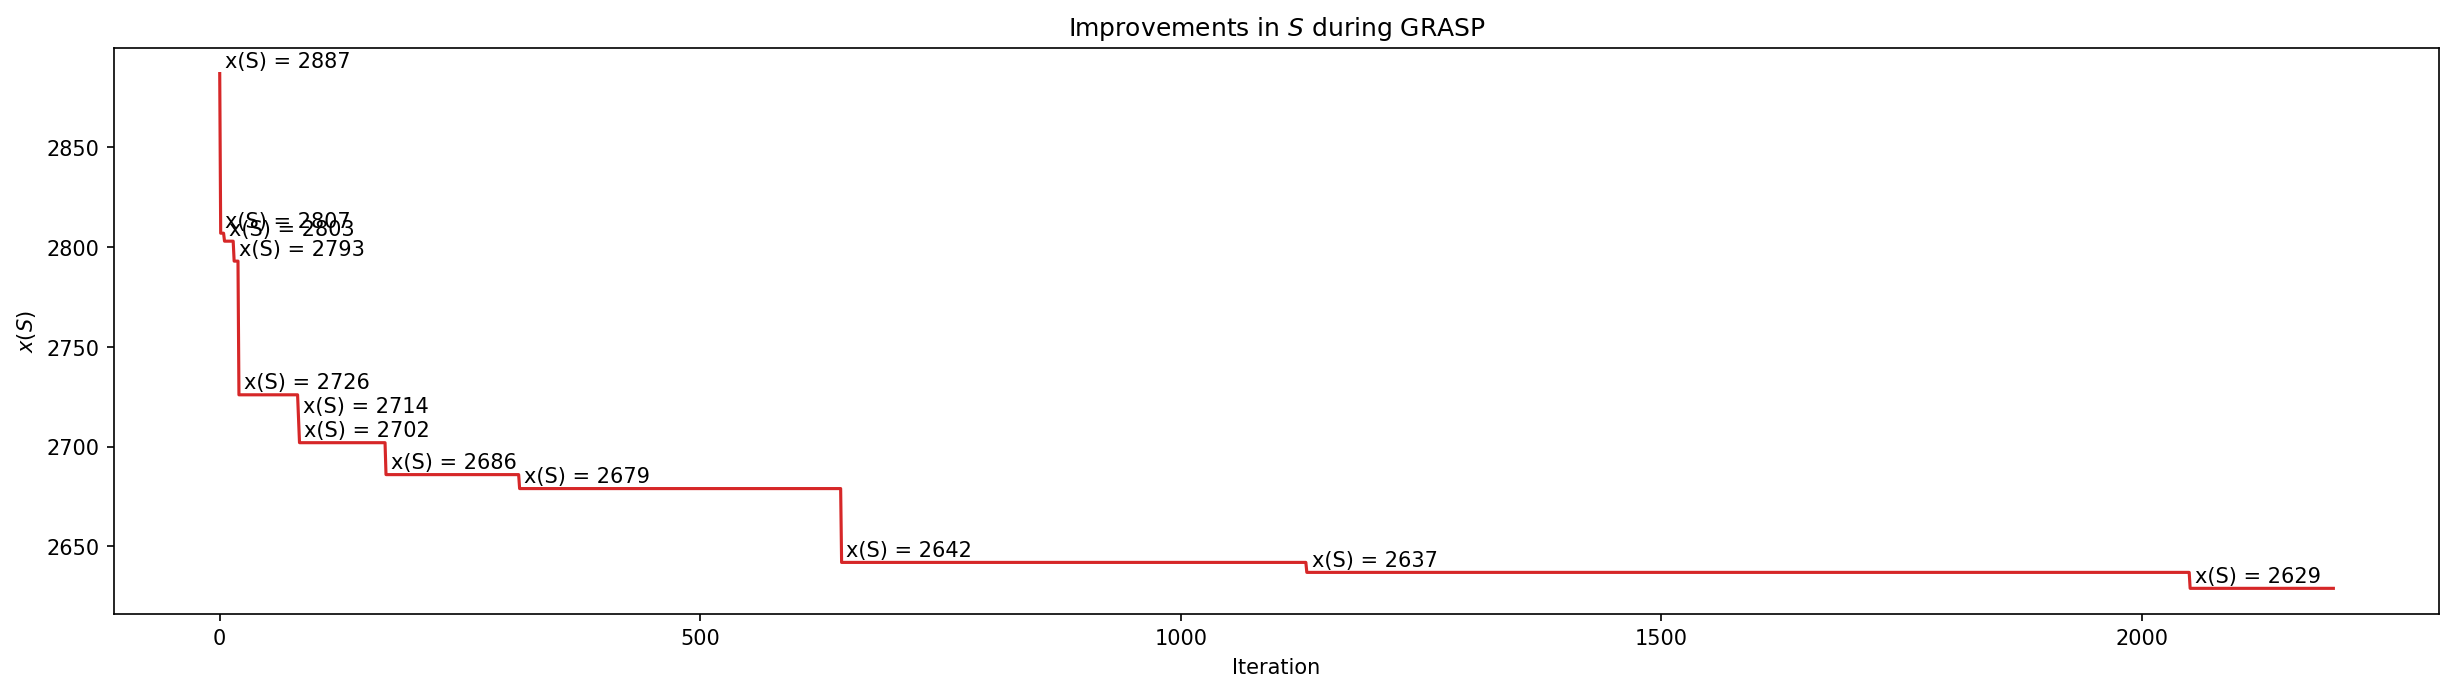

In [57]:
plot_improvs(
    iters, 2200, 5, 3,
    "tab:blue" if name.endswith("2") else "tab:red",
    f"{DIRPATH}\\iters_plot_{name}.png" if save else ""
)